## 13.2 风格迁移
	上节我们介绍了利用Deep Dream显示一个卷积神经网络某一层学习得到的一些特征，这些特征从底层到顶层，其抽象程度是不一样的。实际上，这些特征还包括风格（style）重要信息，风格迁移目前有三种风格，具体如下：
- 第一种为普通风格迁移（A Neural Algorithm of Artistic Style），其特点是固定风格固定内容，这是很经典的一种风格迁移方法；
- 第二种为快速风格迁移（Perceptual Losses for Real-Time Style Transfer and Super-Resolution），其特点是固定风格任意内容；
- 第三种是极速风格迁移（Meta Networks for Neural Style Transfer），其特点是任意风格任意内容。这节我们主要介绍第一种普通风格迁移。  
基于神经网络的普通图像风格迁移是德国Gatys等人在2015年提出的，其主要原理是将参考图像的风格应用于目标图像，同时保留目标图形的内容，如图13-4所示。
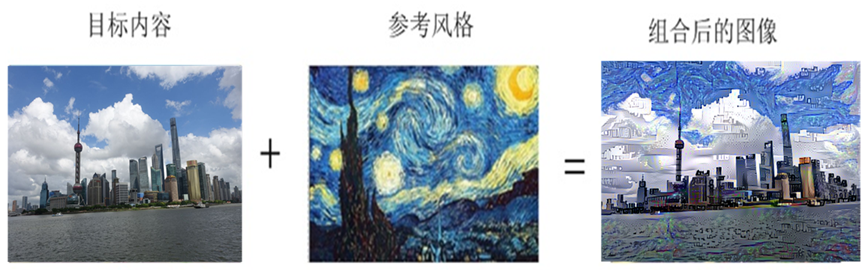
<center>图13-4 一个风格迁移的示例</center>  
	实现风格迁移核心思想就是定义损失函数，如何定义损失函数就成为解决问题的关键。这个损失函数应该包括内容损失和风格损失，这里的损失包括风格损失和内容损失。用公式来表示就是：


## 导入需要的库

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = '../data/generative_net/wt01.png'
style_reference_image_path = '../data/generative_net/start-night.png'
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

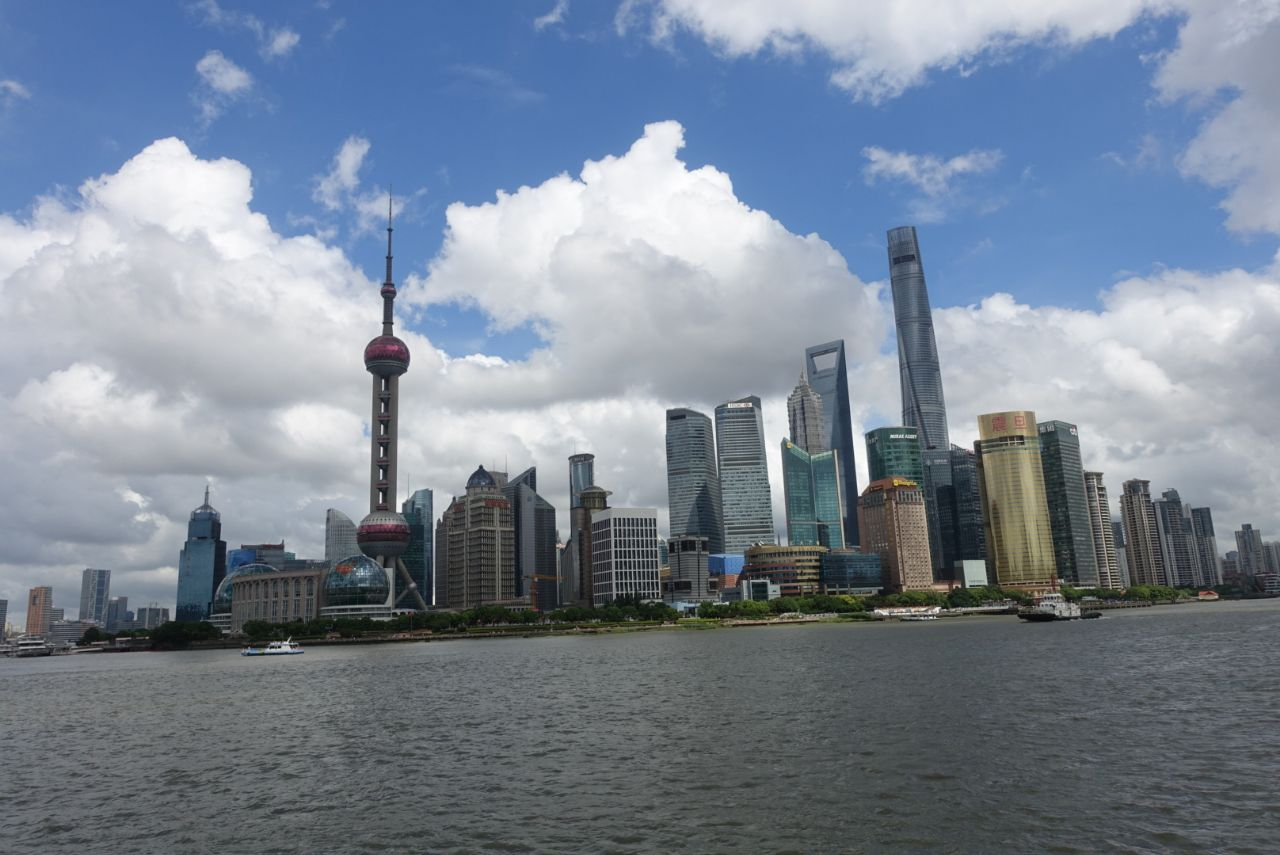

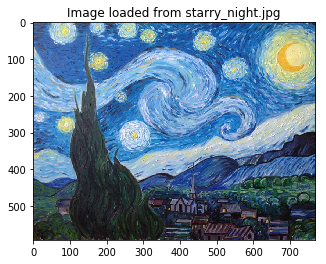

In [2]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

## 对图像进行预处理

In [3]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## 计算风格迁移的损失函数

In [4]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :] )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :] )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

## 创建特征抽签模型

In [5]:
# 构建一个VGG19模型，加载基于ImageNet的预先训练权重
model = vgg19.VGG19(weights="imagenet", include_top=False)

# 获取每个“关键”层的符号输出
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# 建立一个模型，返回VGG19中每个层的激活值.
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

## 计算风格迁移损失函数的值

In [6]:
# 用于风格损失的网络层列表.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# 用于内容损失的网络层.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # 初始化损失值
    loss = tf.zeros(shape=())

    # 添加内容损失
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # 添加分格损失
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # 添加总的变化损失
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

## 转换为静态图模式

In [7]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## 训练模型

In [8]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 1000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=13423.31
Iteration 200: loss=10976.60
Iteration 300: loss=9976.26
Iteration 400: loss=9406.52
Iteration 500: loss=9025.41
Iteration 600: loss=8745.30
Iteration 700: loss=8527.74
Iteration 800: loss=8355.53
Iteration 900: loss=8212.21
Iteration 1000: loss=8092.30


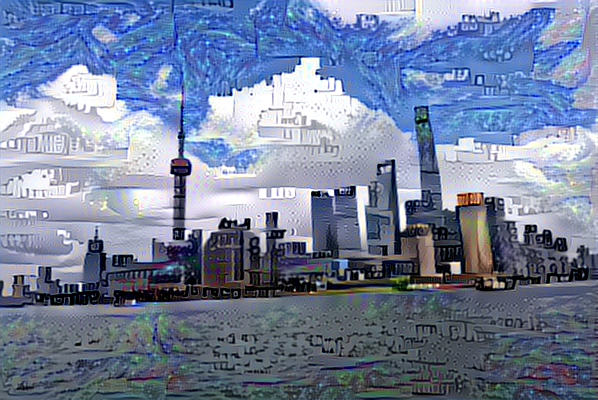

In [9]:
display(Image(result_prefix + "_at_iteration_1000.png"))